In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [21]:
df = pd.read_csv("combined_results.csv")

metric = "RMSE"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LinearRegressor', 'LogisticRegression' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

Split 'umap_split': baseline RMSE per task:
 task_id
361072      2.332328
361073      5.153376
361074      0.001957
361076      0.794131
361077      0.000165
361078      0.310067
361079      0.945192
361080      0.226141
361081      0.053354
361082      0.790735
361083      0.482896
361084      0.222978
361085      0.025192
361086      0.109243
361087      0.141332
361088      0.680735
361093      0.391686
361094      0.115700
361096      0.103604
361097      6.995714
361098      0.111078
361099      0.385235
361101      0.467330
361102      0.244157
361103      0.430165
361104      0.091630
361279      0.025171
361280      2.385479
361281      3.053458
361287      0.024311
361288      1.864481
361289    387.240482
361291      3.088357
361292      0.584718
361293      1.870397
361294      0.109243
dtype: float64
Split 'umap_split': overall lowest RMSE = 0.0001650232160601



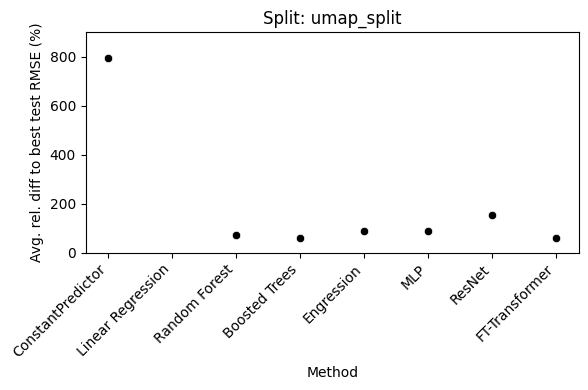

Split 'kmedoids_split': baseline RMSE per task:
 task_id
361093      0.066151
361094      2.487881
361096      0.127109
361097      8.726363
361098      0.114653
361099      0.478360
361101      0.401873
361102      0.189011
361103      0.445959
361104      0.012996
361287      0.025860
361288      2.234810
361289    406.886416
361291      2.964260
361292      0.553396
361293      1.906235
361294      0.192742
dtype: float64
Split 'kmedoids_split': overall lowest RMSE = 0.0129963745239596



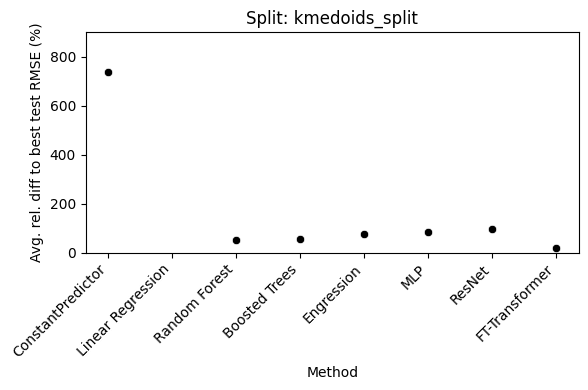

Split 'gower_split': baseline RMSE per task:
 task_id
361093      0.066522
361094      1.682160
361096      0.144777
361097      9.238517
361098      0.153222
361099      0.532168
361101      0.475539
361102      0.260366
361103      0.422753
361104      0.031202
361287      0.026459
361288      2.307722
361289    423.462311
361291      2.963809
361292      0.561039
361293      1.995108
361294      0.298026
dtype: float64
Split 'gower_split': overall lowest RMSE = 0.0264588635892774



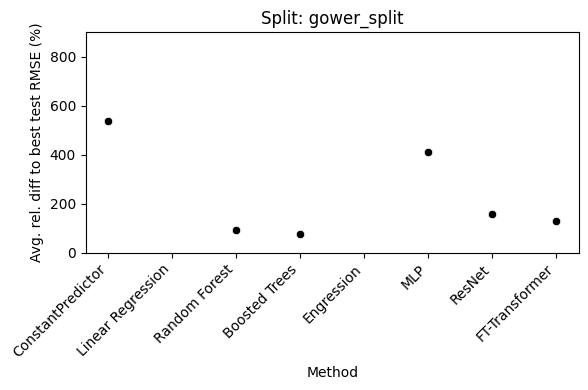

Split 'mahalanobis_split': baseline RMSE per task:
 task_id
361072    4.342733
361073    5.959149
361074    0.002376
361076    0.755962
361077    0.000216
361078    0.273917
361079    1.216632
361080    0.280219
361081    0.264155
361082    0.749067
361083    0.512406
361084    0.227031
361085    0.059187
361086    0.259871
361087    0.276193
361088    1.150162
361279    0.028841
361280    2.201527
361281    3.101494
dtype: float64
Split 'mahalanobis_split': overall lowest RMSE = 0.0002155388043123



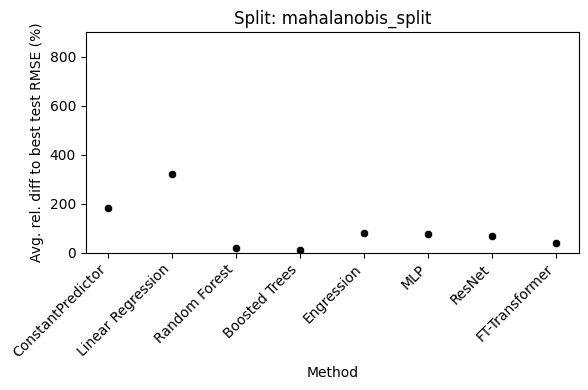

Split 'kmeans_split': baseline RMSE per task:
 task_id
361072    4.915960
361073    9.342769
361074    0.002161
361076    0.705948
361077    0.000213
361078    0.245381
361079    0.866477
361080    0.291708
361081    0.164274
361082    0.561415
361083    0.529586
361084    0.183412
361085    0.042778
361086    0.272956
361087    0.241805
361088    1.231635
361279    0.027874
361280    2.160411
361281    3.067180
dtype: float64
Split 'kmeans_split': overall lowest RMSE = 0.0002130305690047



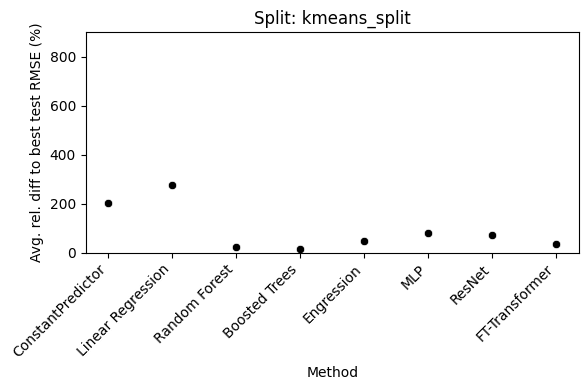

Split 'spatial_depth_split': baseline RMSE per task:
 task_id
361072    4.499054
361073    5.715625
361074    0.002592
361076    0.762108
361077    0.000212
361078    0.276473
361079    1.211294
361080    0.280927
361081    0.164574
361082    0.742096
361083    0.512270
361085    0.058268
361086    0.257815
361087    0.267862
361088    1.137806
361279    0.028564
361280    2.327038
361281    3.088980
dtype: float64
Split 'spatial_depth_split': overall lowest RMSE = 0.0002121086978598



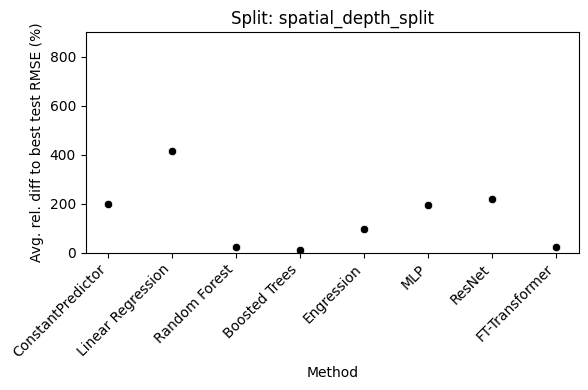

In [22]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    baseline = table.min(axis=0)
    print(f"Split '{split}': baseline RMSE per task:\n", baseline)
    print(f"Split '{split}': overall lowest RMSE = {baseline.min()}\n")

    rel = (table - baseline) / baseline

    summary = pd.DataFrame({
        "Mean": rel.mean(axis=1),
        "Median": rel.median(axis=1),
        "Std": rel.std(axis=1)
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = summary["Method"].astype(str).map(rename_map).fillna(summary["Method"].astype(str))

    summary["Mean"] = 100 * summary["Mean"]

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=summary, x="Method", y="Mean", color='black')
    plt.xlabel("Method")
    plt.ylabel("Avg. rel. diff to best test RMSE (%)")
    plt.title(f"Split: {split}")
    plt.ylim(0, 900)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    fname = f"{split}_relative_diff_{metric}.png"
    plt.savefig(os.path.join(outdir, fname), bbox_inches='tight')
    plt.show()




In [34]:
df = df[df["metric"] == "RMSE"]

df = df[df["split_method"] != "random_split"]


=== RAW relative_difference sample ===
       split_method  task_id                  model        value  baseline  \
460      umap_split   361093        LinearRegressor     1.010513  0.391686   
462      umap_split   361093      ConstantPredictor     1.188115  0.391686   
464  kmedoids_split   361093        LinearRegressor     0.498135  0.066151   
466  kmedoids_split   361093      ConstantPredictor     0.674505  0.066151   
468     gower_split   361093        LinearRegressor     0.591701  0.066522   
470     gower_split   361093      ConstantPredictor     0.723444  0.066522   
480     gower_split   361093             Engression  1159.723984  0.066522   
482     gower_split   361093                    MLP     0.092087  0.066522   
484     gower_split   361093                 ResNet     0.124924  0.066522   
486     gower_split   361093          FTTransformer     0.066522  0.066522   
488  kmedoids_split   361093             Engression     0.324660  0.066151   
490  kmedoids_split   36

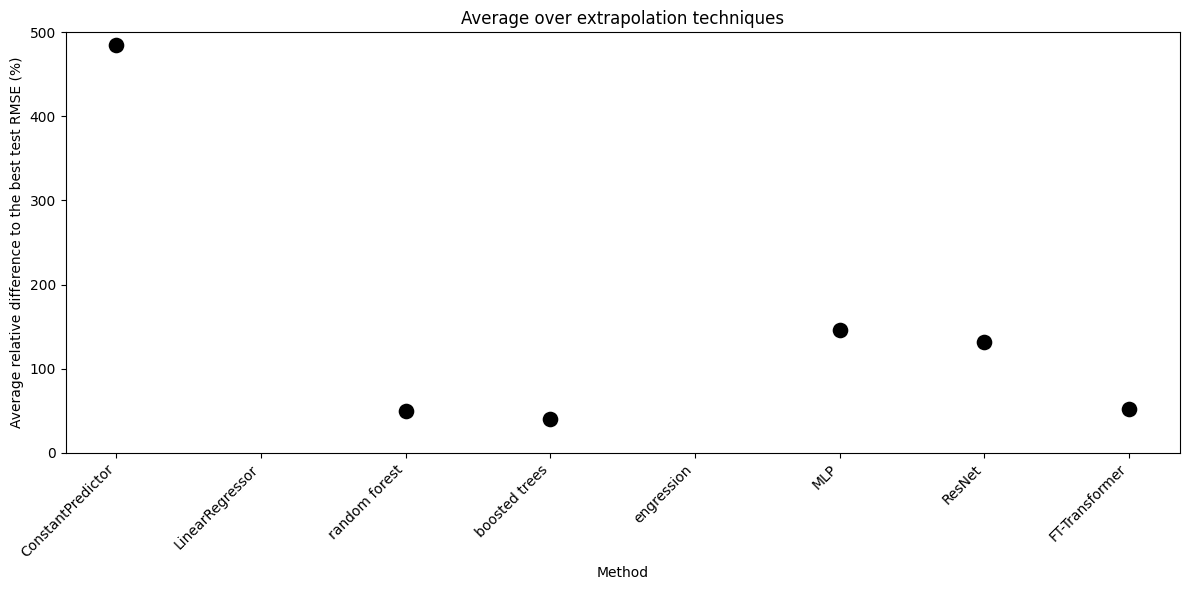

In [42]:
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("min")
)

df["relative_difference"] = (df["value"] - df["baseline"]) / df["baseline"]

print("\n=== RAW relative_difference sample ===")
print(df[['split_method','task_id','model','value','baseline','relative_difference']].head(20))

print("\n=== per-model relative_difference summary ===")
print(df.groupby('model')['relative_difference']
        .agg(count='count', mean='mean', min='min', max='max')
        .sort_values('mean', ascending=False)
     )

print("\n=== model appearance counts ===")
print(df.groupby('model')['relative_difference']
        .count()
        .sort_values(ascending=False)
     )

# 3) Compute overall mean per model
# --- assume df already has 'relative_difference' computed and filtered ---

# 1) Compute overall average per raw model name
overall = (
    df
    .groupby('model')['relative_difference']
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100  # to percent

# 2) Enforce complete ordering on the raw model keys
method_order = [
    'ConstantPredictor', 'LinearRegressor',
    'RandomForestClassifier', 'RandomForestRegressor',
    'LGBMClassifier', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

# 3) Map to display names
rename_map = {
    'RandomForestClassifier':'random forest',
    'RandomForestRegressor':'random forest',
    'LGBMClassifier':       'boosted trees',
    'LGBMRegressor':        'boosted trees',
    'Engression':           'engression',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'DGBT':                 'DGBT',
    'DRF':                  'DRF',
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])


plt.figure(figsize=(12,6))
sns.scatterplot(data=overall, x='Method', y='Mean', color='black', s=150)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average relative difference to the best test RMSE (%)')
plt.xlabel('Method')
plt.title('Average over extrapolation techniques')
plt.ylim(0, 500)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/average_over_extrapolation_techniques_RMSE_fixed.png', bbox_inches='tight')
plt.show()
